### Definición de funciones
Aqui defino algunas funciónes para leer los archivos y hacer la primera visualización de un espacio K2-Dimensional.

In [ ]:
import plotly.graph_objects as go

# Function to read trees from a given filename
def read_trees_from_file(filename):
    trees = []

    with open(filename, 'r') as file:
        num_trees = int(file.readline().strip())

        for _ in range(num_trees):
            line = file.readline().strip()
            if not line:
                continue

            try:
                num_nodes, dimensionality, num_queries = map(int, line.split()[:3])
                queries = [list(map(float, file.readline().split())) for _ in range(num_queries)]
            except ValueError:
                print(f"Error while reading tree details: {line}")
                continue

            components = []
            for _ in range(num_nodes):
                comp_line = file.readline().strip()
                if not comp_line:
                    print(f"Error while reading components for tree with {num_nodes} nodes and {dimensionality} dimensions.")
                    break

                components.append(list(map(float, comp_line.split())))

            trees.append((dimensionality, components, queries))

    return trees

# Function to plot trees using plotly
def plot_trees(trees):
    traces = []

    for i, (dimensionality, components, queries) in enumerate(trees, 1):
        if dimensionality == 2:
            x_vals = [comp[0] for comp in components]
            y_vals = [comp[1] for comp in components]
            traces.append(go.Scatter(x=x_vals, y=y_vals, mode='markers', name=f'Tree {i}'))

            # Plotting queries
            query_x_vals = [query[0] for query in queries]
            query_y_vals = [query[1] for query in queries]
            traces.append(go.Scatter(x=query_x_vals, y=query_y_vals, mode='markers', marker=dict(color='red'), name='Queries'))

    layout = go.Layout(title="2D representation of k-dimensional trees with Queries",
                       xaxis=dict(title="X-axis", scaleanchor="y"),
                       yaxis=dict(title="Y-axis"),
                       width=1000, height=1000)

    fig = go.Figure(data=traces, layout=layout)
    fig.show()

# Main execution starts here
if __name__ == "__main__":
    filename = "inputs/k2/kdTree_N96000_K2_T100_Q10000.txt"
    trees = read_trees_from_file(filename)
    plot_trees(trees)


## Graficando los Kd-Tree
A continuación definimos algunas funciones auxiliares que nos ayudaran a graficar.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_mean_from_file(filename):
    with open(filename, 'r') as file:
        # Leer el número de árboles, no se usará en este caso
        num_trees = int(file.readline().strip())
        total_mean = 0
        nodes = []
        for _ in range(num_trees):
          # Leer la dimensión k y el número de consultas
          k, num_queries = map(int, file.readline().split())

          # Contador para acumular el total de nodos explorados
          total_nodes_explored = 0
          # Leer cada línea de consulta y sumar los nodos explorados
          for _ in range(num_queries):
              components = file.readline().split()
              nodes_explored = int(components[-1])  # El último elemento es el número de nodos explorados
              nodes.append(nodes_explored)
              total_nodes_explored += nodes_explored
          mean_nodes_explored = total_nodes_explored / num_queries
          total_mean = total_mean + mean_nodes_explored


    return nodes, total_mean/num_trees

def plot_dataframe(results, method):
    """
    Traza un gráfico de la columna 'Y' en función de la columna 'X' de un DataFrame.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene las columnas 'X' y 'Y'.
    """
    plt.figure(figsize=(10, 6))

    for k in reversed(range(2, 7)):
        plt.plot(results[k][method]['X'], results[k][method]['Y'], '-o', label ="n^a + log(n) K" + str(k) + " " + method)
    #plt.plot(df2['X'], results2['Y'], '-o', color='blue', label ="n^a + log(n) SQ")
    plt.plot(results[2]['STANDARD']['X'], np.log(results[2]['STANDARD']['X']), '-o', color='green', label="log(n)")
    plt.xlabel('Mida de l\'arbre (X)')
    plt.ylabel('Nodes explorats (Y)')
    plt.title('Gràfica Kd')
    plt.grid(True)
    plt.legend()  # Muestra la leyenda
    plt.show()

def plot_dataframe_log(results, method):
    """
    Traza un gráfico de la columna 'Y' en función de la columna 'X' de un DataFrame.

    Parameters:
    - results (pd.DataFrame): El DataFrame que contiene las columnas 'X' y 'Y'.
    """
    plt.figure(figsize=(10, 6))

    for k in reversed(range(2, 7)):
        plt.plot(results[k][method]['X'], np.log(results[k][method]['Y'])/np.log(results[k][method]['X']), '-o', label ="log(Cn)/log(n) para K" + str(k) + " " + method)
    #plt.plot(df2['X'], df2['Y'], '-o', color='blue', label ="n^a + log(n) SQ")
    #plt.loglog(results[2]['STANDARD']['X'], np.log(results[2]['STANDARD']['X']), '-o', color='green', label="log(n)")
    plt.xlabel('Mida de l\'arbre (X)')
    plt.ylabel('Nodes explorats (Y)')
    plt.title('Gràfica k-d')
    plt.grid(True)
    plt.legend()  # Muestra la leyenda
    plt.show()



def plot_boxplot_log(nodes):
    fig, axs = plt.subplots(5, 3, figsize=(48, 48))

    for k in range(2, 7):
        for i, method in enumerate(["STANDARD", "SQUARISH", "RELAXED"]):
            # Recopilar los datos de todos los valores de N en una lista de listas
            data_to_plot = []
            for N in nodes[k][method].keys():
                data_to_plot.append(nodes[k][method][N])


            # Boxplot de todos los datos recopilados
            axs[k-2, i].boxplot(data_to_plot)

            # Establecer las etiquetas del eje x como los valores de N
            axs[k-2, i].set_xticks(range(1, len(nodes[k][method]) + 1))
            axs[k-2, i].set_xticklabels([str(N) for N in nodes[k][method]])

            axs[k-2, i].grid(True)
            axs[k-2, i].set_title('K'+str(k) + " " + method)

    plt.tight_layout()
    plt.show()





## Estimación del parametro $\zeta$

El siguiente codigo procesa los datos de los ficheros y los movemos a un DataFrame de Panda.

In [3]:
import os
import pandas as pd
from pandas.plotting import scatter_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 3)

types = ["STANDARD", "SQUARISH", "RELAXED"]

results = {}
resultsNodes = {}
from collections import defaultdict
results = defaultdict(dict)
resultsNodes = defaultdict(dict)
for k in range(2, 7):
    resultsNodes[k] = defaultdict(dict)
    for method in types:
        resultsNodes[k][method] = defaultdict(dict)
        directory_path = 'results/K'+ str(k) +'/'+ method  # Replace with your directory path

        # Get all files in the directory
        files_in_directory = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

        X = []
        Y = []

        nodes = []
        for file_name in files_in_directory:
          print(file_name)
          T = int(file_name.split('_')[4][1:])
          K = int(file_name.split('_')[3][1:])

          N = int(file_name.split('_')[2][1:])
          Q = int(file_name.split('_')[5][1:].split('.')[0])

          file_route = directory_path + "/" + file_name
          nodes, mean = calculate_mean_from_file(file_route)
          #df = pd.DataFrame([nodes]).T
          #df = df.sort_values(by='X')
          #df.columns = ['nodes']
          X.append(N)
          Y.append(mean)
          resultsNodes[k][method][N] = nodes

        resultsNodes[k][method] = defaultdict(dict, sorted(resultsNodes[k][method].items()))
        # Guardar X,Y en el dataframe
        df = pd.DataFrame({'X': X, 'Y': Y})
        df = df.sort_values(by='X')

        results[k][method] = df
        print("Procesados el K"+str(k) + ", con el metodo " + method)


  #print("File: " + file_name + " has " + str(mean) + " nodes searched mean.")



results_kdTree_N1000_K2_T100_Q10000.txt
results_kdTree_N101000_K2_T100_Q10000.txt
results_kdTree_N106000_K2_T100_Q10000.txt
results_kdTree_N11000_K2_T100_Q10000.txt
results_kdTree_N16000_K2_T100_Q10000.txt
results_kdTree_N21000_K2_T100_Q10000.txt
results_kdTree_N26000_K2_T100_Q10000.txt
results_kdTree_N31000_K2_T100_Q10000.txt
results_kdTree_N36000_K2_T100_Q10000.txt
results_kdTree_N41000_K2_T100_Q10000.txt
results_kdTree_N46000_K2_T100_Q10000.txt
results_kdTree_N51000_K2_T100_Q10000.txt
results_kdTree_N56000_K2_T100_Q10000.txt
results_kdTree_N6000_K2_T100_Q10000.txt
results_kdTree_N61000_K2_T100_Q10000.txt
results_kdTree_N66000_K2_T100_Q10000.txt
results_kdTree_N71000_K2_T100_Q10000.txt
results_kdTree_N76000_K2_T100_Q10000.txt
results_kdTree_N81000_K2_T100_Q10000.txt
results_kdTree_N86000_K2_T100_Q10000.txt
results_kdTree_N91000_K2_T100_Q10000.txt
results_kdTree_N96000_K2_T100_Q10000.txt
Procesados el K2, con el metodo STANDARD
results_kdTree_N1000_K2_T100_Q10000.txt
results_kdTree_N1

## Graficas Kd
Graficamos los plots

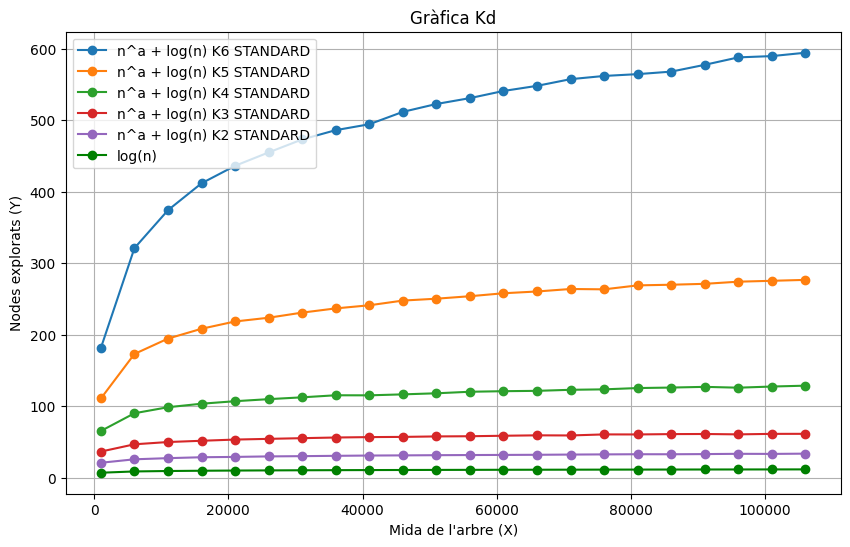

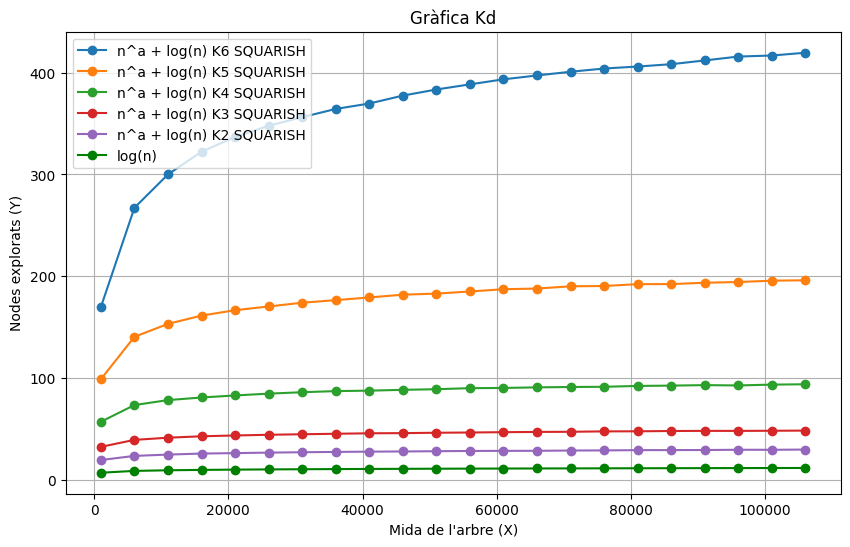

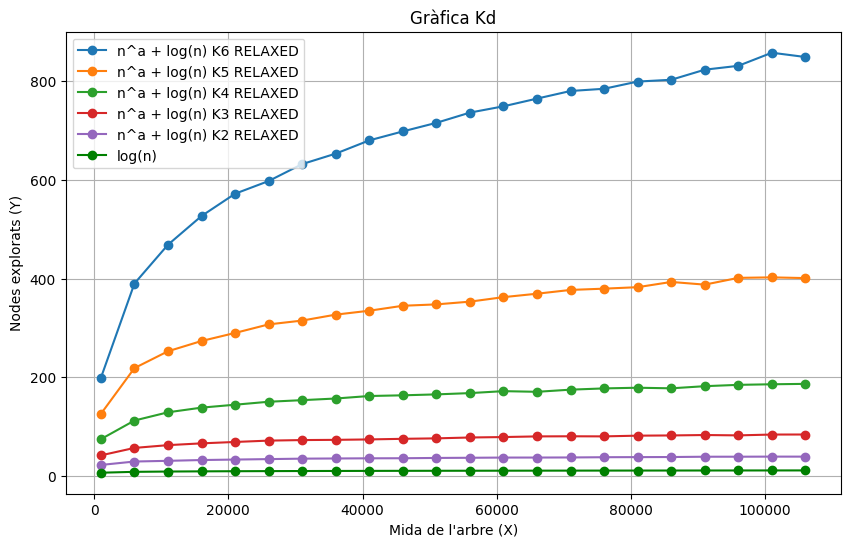

In [14]:
plot_dataframe(results, "STANDARD")
plot_dataframe(results, "SQUARISH")
plot_dataframe(results, "RELAXED")




Graficamos los boxplot para ver la variancia.

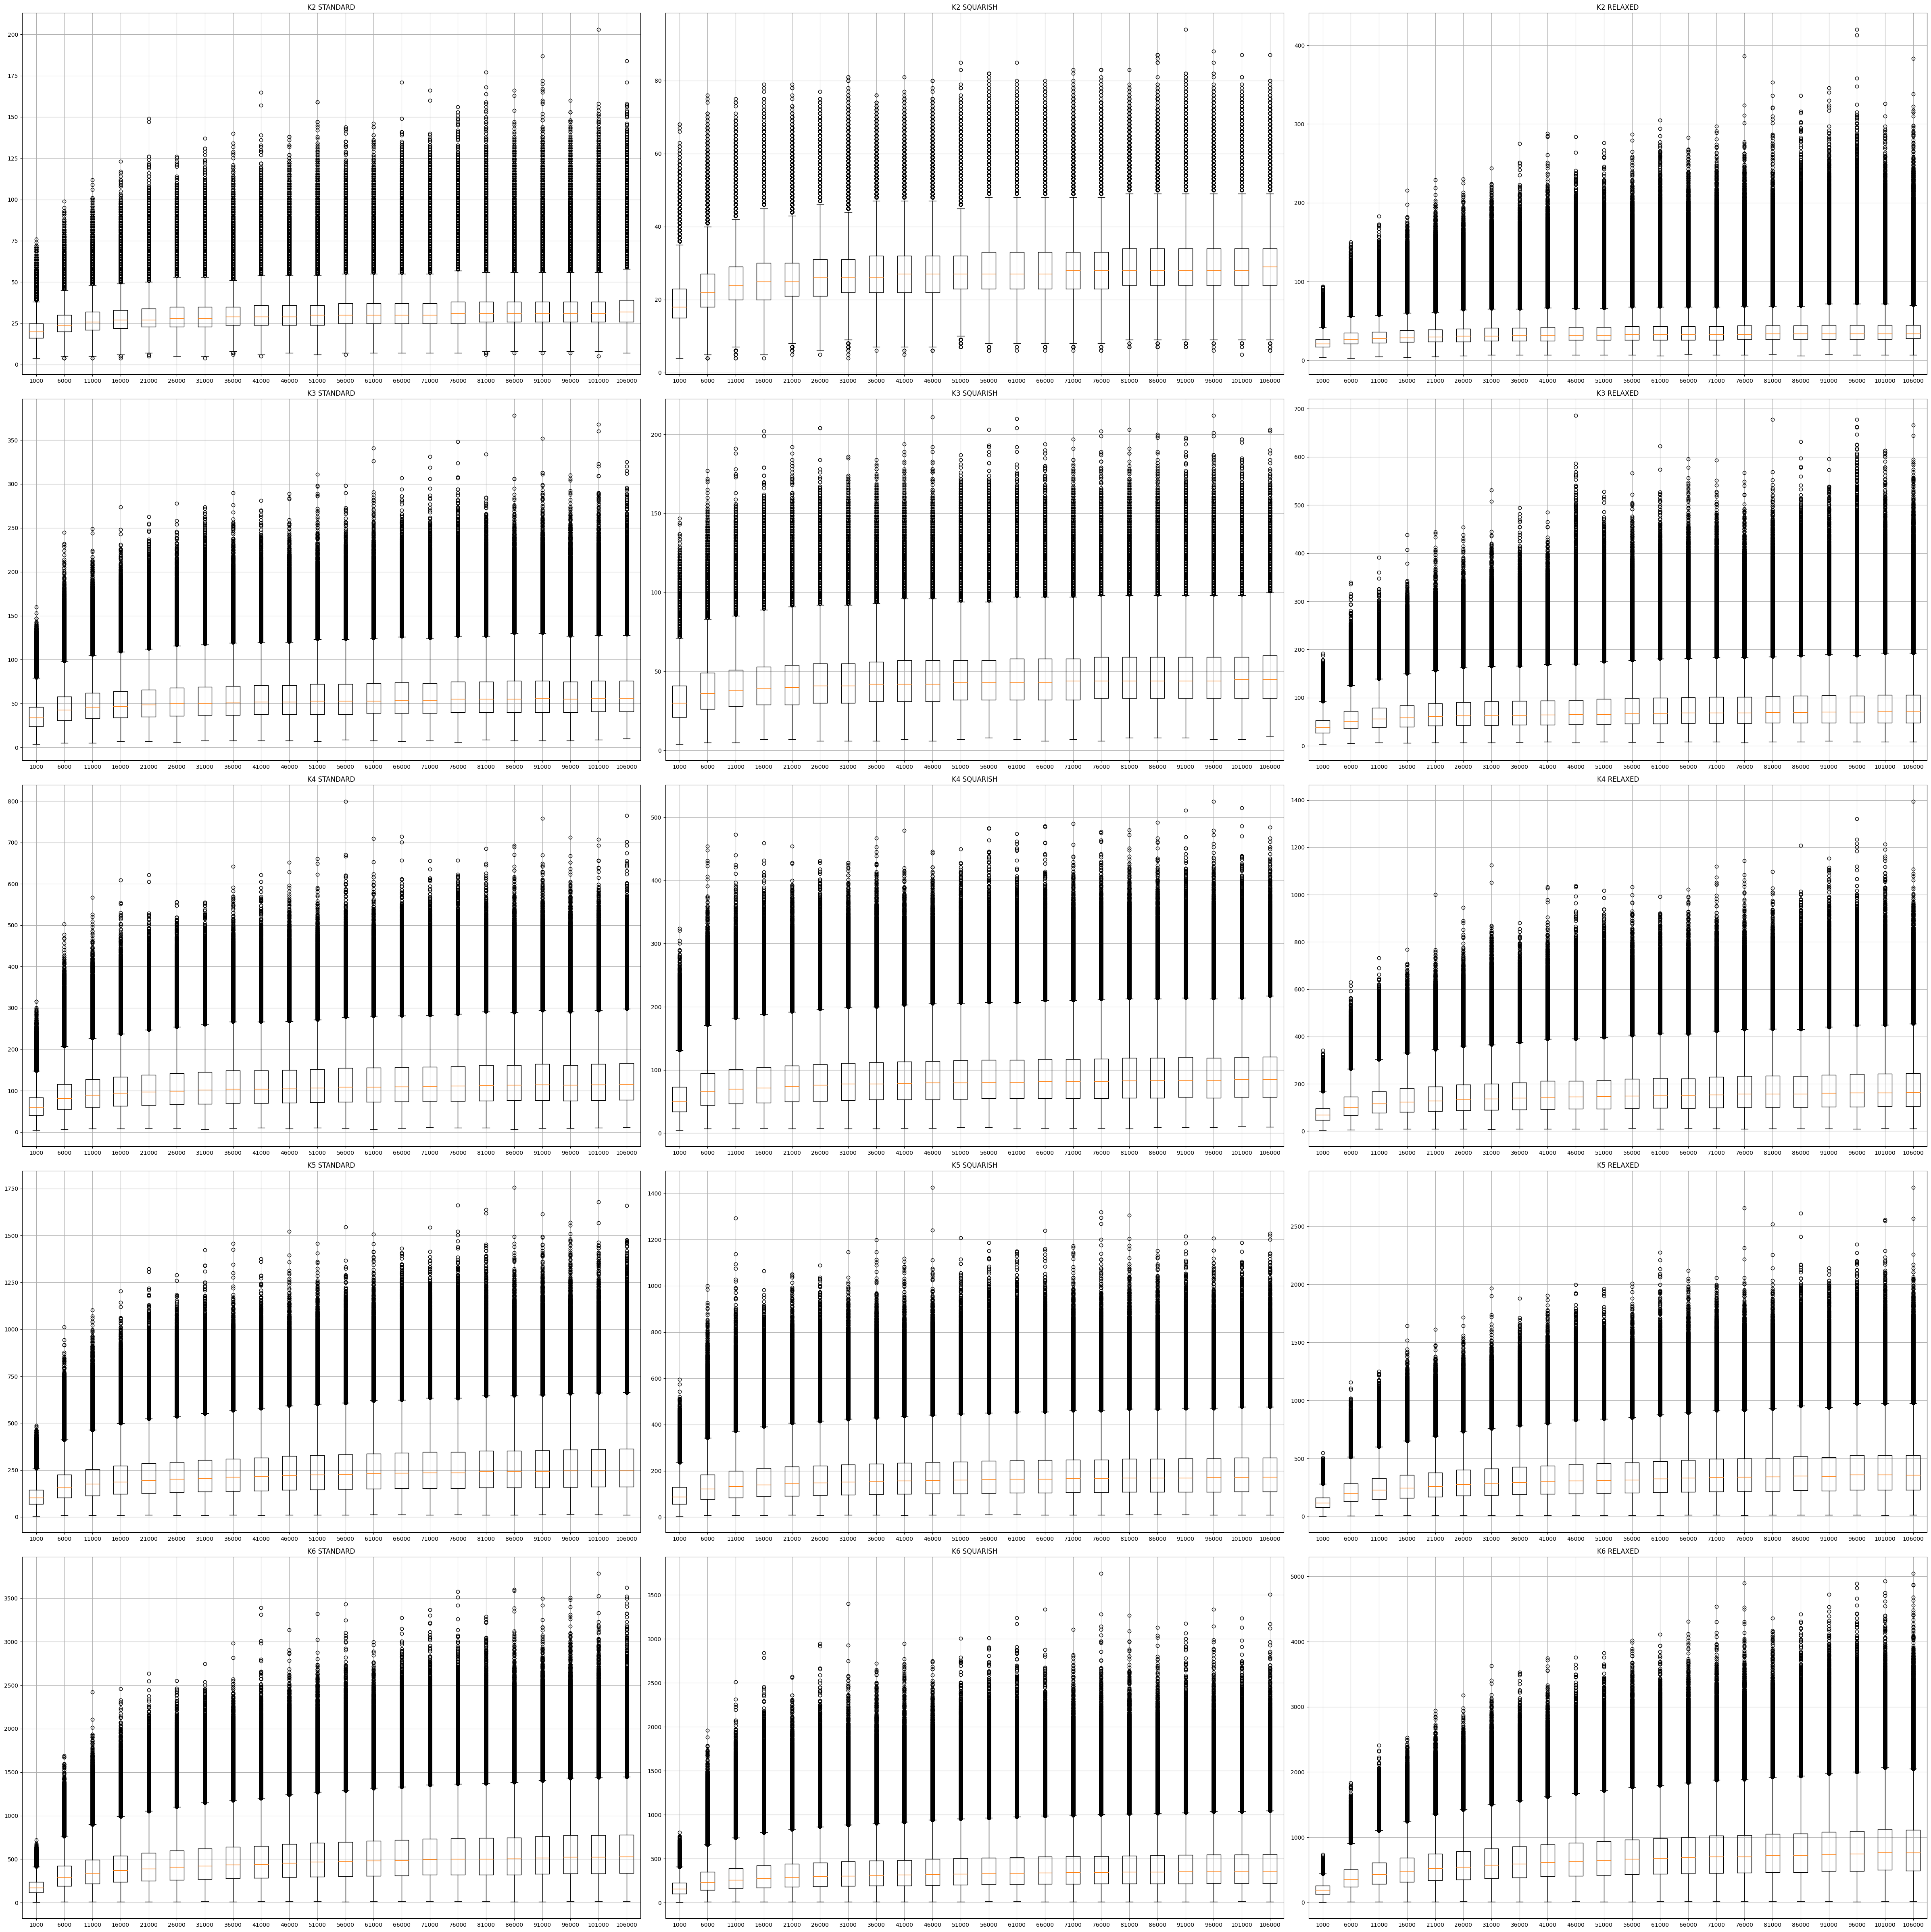

In [5]:
plot_boxplot_log(resultsNodes)

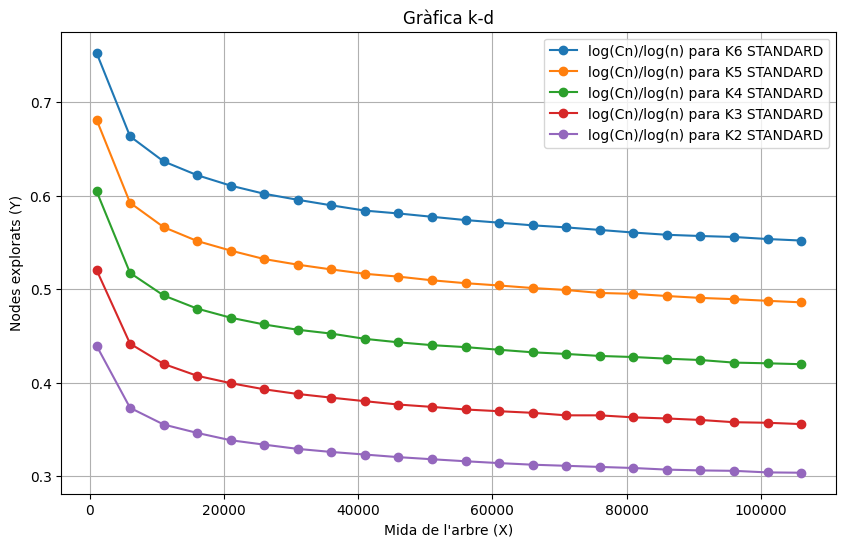

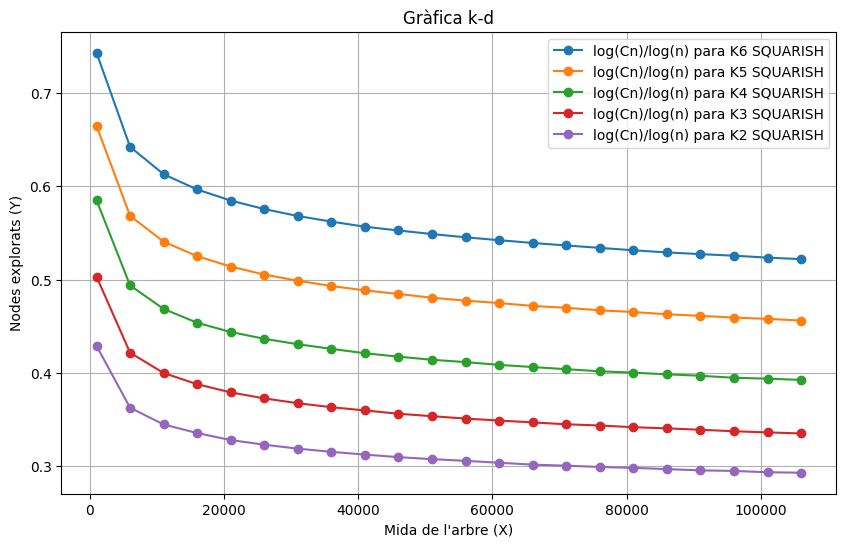

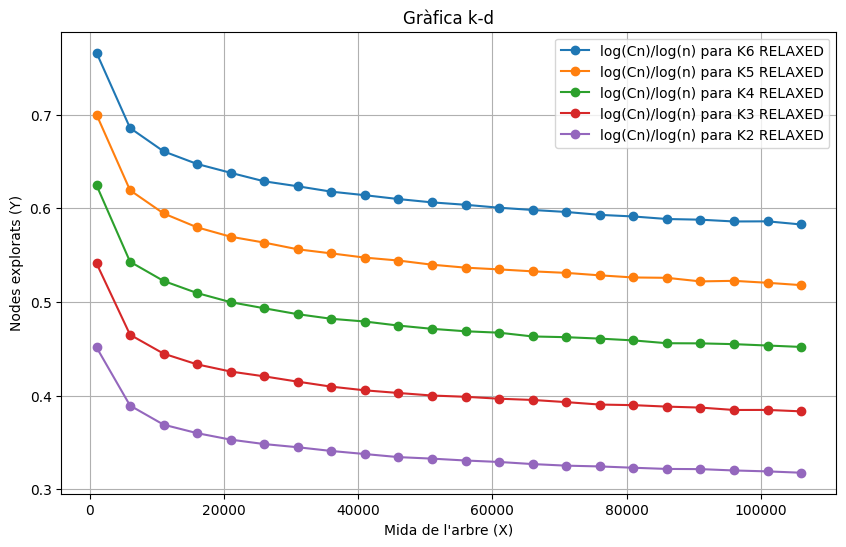

In [15]:
plot_dataframe_log(results, "STANDARD")
plot_dataframe_log(results, "SQUARISH")
plot_dataframe_log(results, "RELAXED")

## Estimando el $\zeta$

K=2, Método=STANDARD
Estimated z: 1.1660633401698656e-07 with cov: 10052282593.380438
Estimated b: 2.693034280325932 with cov: -9361257885.389994
Estimated c: 0.9312547348174152 with cov: -1231202660.2304924
Estimated d: 0.9312547348174152 with cov: 1231306607.8804386
R^2:0.9988752772641306
K=2, Método=SQUARISH
Estimated z: 5.4228039893158136e-08 with cov: 11288909657.84225
Estimated b: 2.1671861970061723 with cov: -108.7743055527557
Estimated c: 3.759660856855461e-08 with cov: -2342293377.671215
Estimated d: 3.759660856855461e-08 with cov: 2342291567.29946
R^2:0.9988127561882647
K=2, Método=RELAXED
Estimated z: 7.03934613637755e-05 with cov: 0.0
Estimated b: 3.398714579339318 with cov: 0.0
Estimated c: 8.37395527665669e-14 with cov: 0.0
Estimated d: 8.37395527665669e-14 with cov: 0.0
R^2:0.9940548954144233
K=3, Método=STANDARD
Estimated z: 0.000156736760698342 with cov: 314508450806.4587
Estimated b: 5.318586028735354 with cov: 20931704.72190911
Estimated c: 5.241933782179631e-08 with

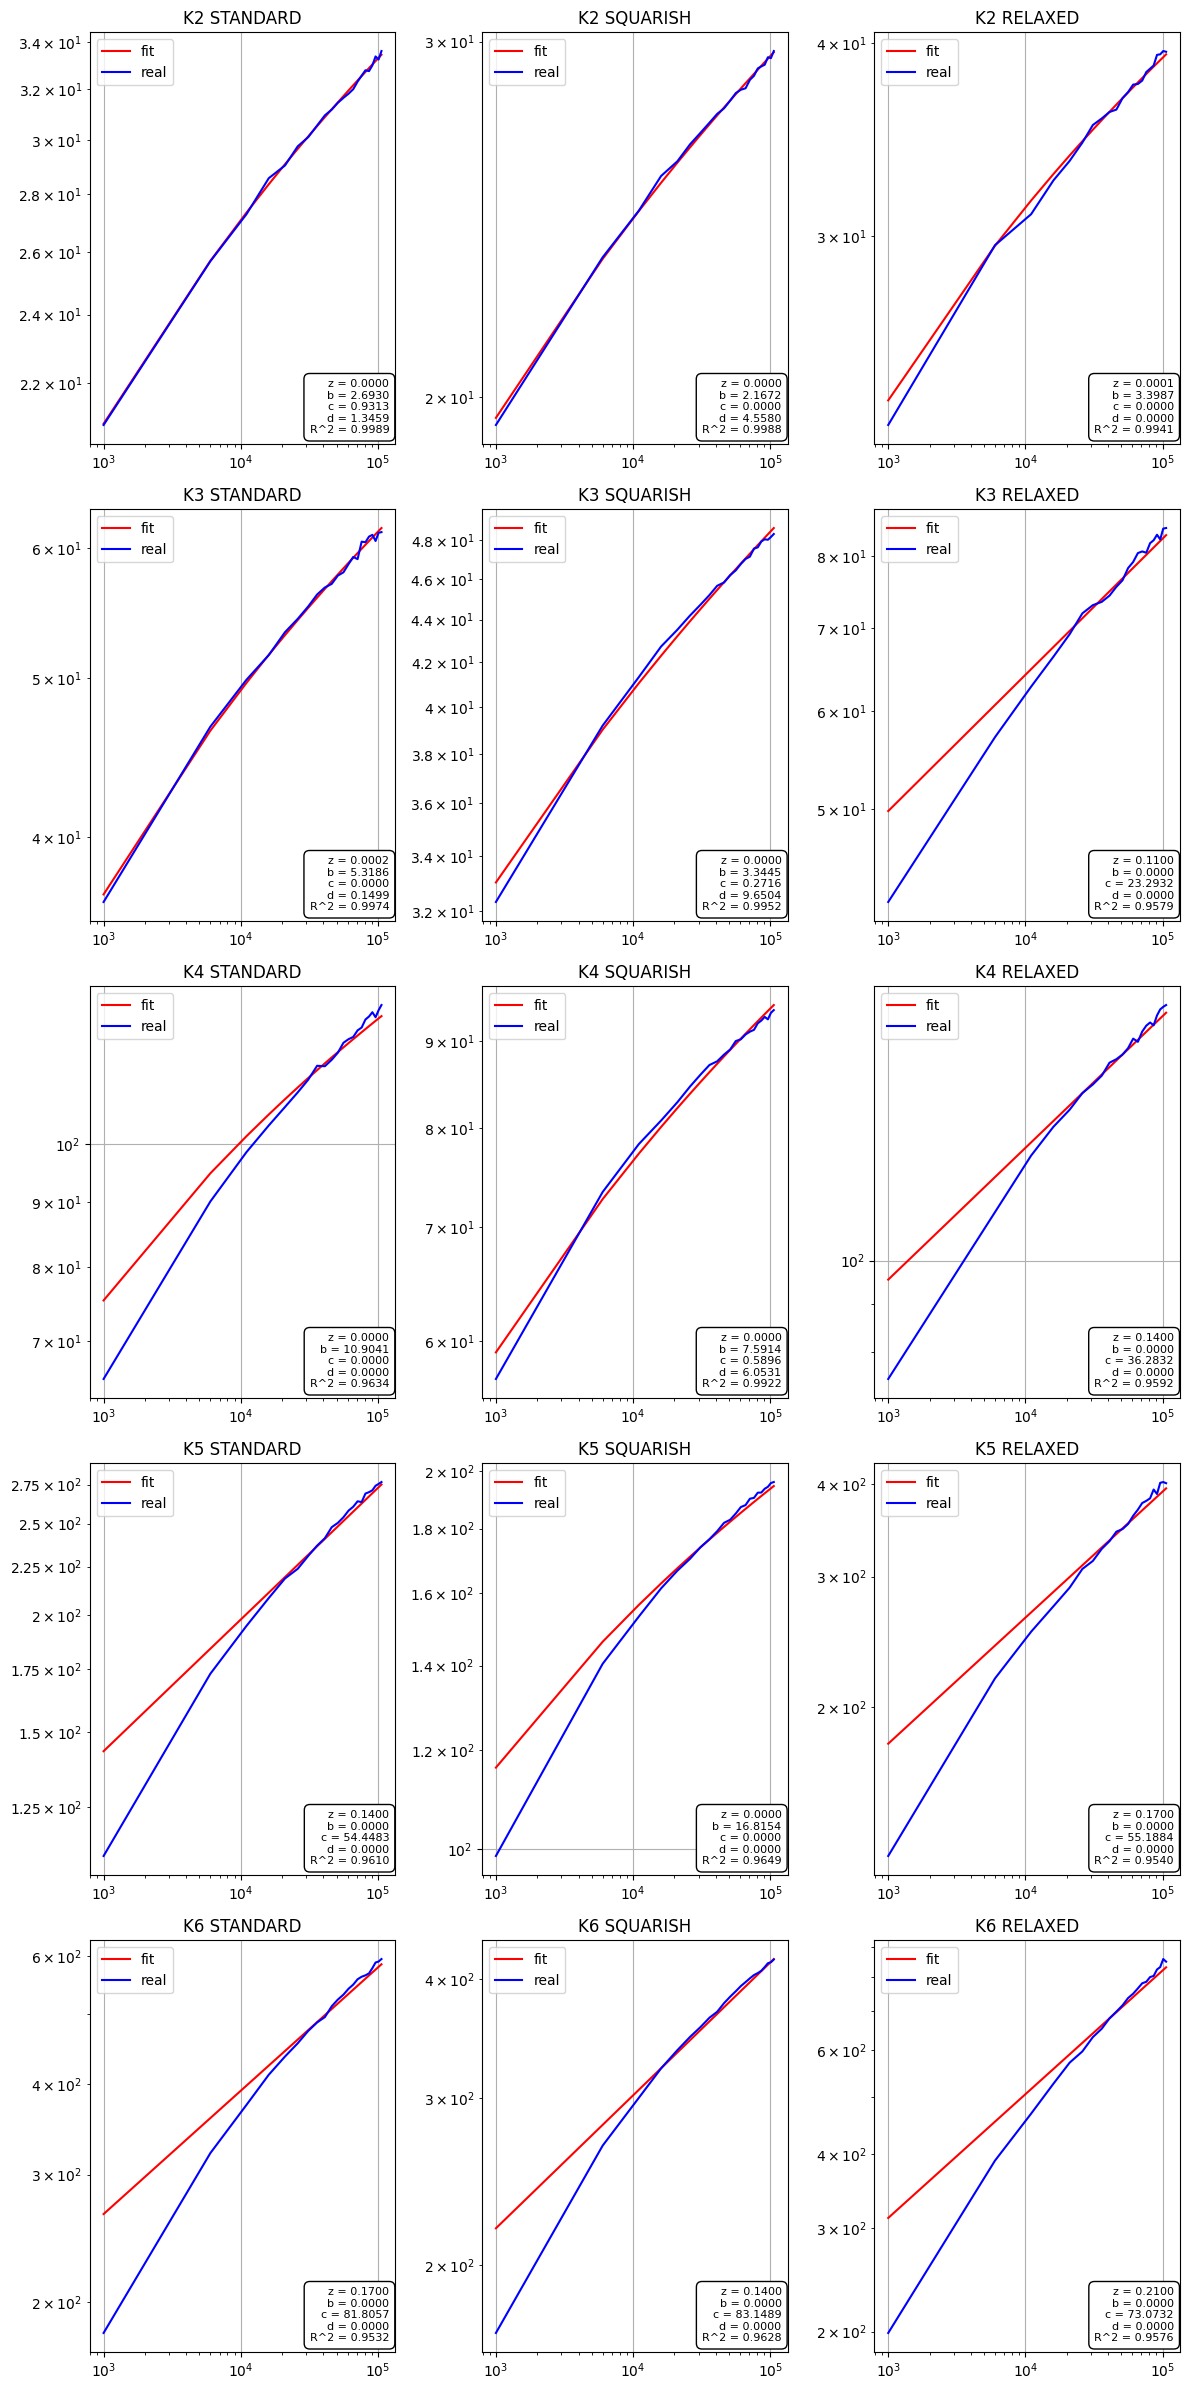

In [9]:
# Función objetivo
def objective_function(n, a,b,c,d ):
    return c*pow(n, a) + b*np.log(n) +d

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


def residualR(X, Y):
    residuals = Y- objective_function(X, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Y-np.mean(Y))**2)
    return 1 - (ss_res / ss_tot)

# Define la figura y los ejes con 6 filas y 3 columnas
fig, axs = plt.subplots(5, 3, figsize=(12, 24))  # 12 pulgadas de ancho (4 por cada columna) y 24 de alto (4 por cada fila)

for k in range(2, 7):  # Esto nos dará 5 valores: 2, 3, 4, 5, 6
    for i, method in enumerate(["STANDARD", "SQUARISH", "RELAXED"]):
        min_z = 0.01
        R_conf = 0.95
        r_squared = 0.00
        while (r_squared< R_conf):

            popt, pcov = curve_fit(objective_function, results[k][method]['X'], results[k][method]['Y'], bounds=(0, [min_z, np.inf, np.inf, np.inf]))
            r_squared = residualR(results[k][method]['X'], results[k][method]['Y'])
            min_z = min_z + 0.01

        axs[k-2, i].loglog(results[k][method]['X'], objective_function(results[k][method]['X'], *popt), 'r-', label='fit')
        axs[k-2, i].loglog(results[k][method]['X'], results[k][method]['Y'], linestyle='-', color='blue', label='real')

        # ajusta las coordenadas de texto si es necesario
        custom_text = f"z = {popt.item(0):.4f}\nb = {popt.item(1):.4f}\nc = {popt.item(2):.4f}\nd = {popt.item(3):.4f}\nR^2 = {r_squared:.4f}"  # Puedes ajustar el formato como desees
        axs[k-2, i].text(0.98, 0.02, custom_text, ha='right',fontsize=8, va='bottom', transform=axs[k-2, i].transAxes,
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        axs[k-2, i].grid(True)
        axs[k-2, i].legend()
        axs[k-2, i].set_title('K'+str(k) + " " + method)


        print(f"K={k}, Método={method}")
        print("Estimated z: " + str(popt.item(0)) + " with cov: " + str(pcov.item(0)))
        print("Estimated b: " + str(popt.item(1)) + " with cov: " + str(pcov.item(1)))
        print("Estimated c: " + str(popt.item(2)) + " with cov: " + str(pcov.item(2)))
        print("Estimated d: " + str(popt.item(2)) + " with cov: " + str(pcov.item(3)))
        print("R^2:" + str(r_squared))

# Ajusta el layout después de configurar todos los subplots
fig.tight_layout()

plt.show()




K=2, Método=STANDARD
Estimated z: 0.00011440044695624644 with cov:
Estimated b: 2.6929146468577634 with cov:
Estimated c: 1.0456451191622644 with cov:
Estimated d: 1.2315446541176684 with cov:
R^2: 0.9988752772428526
K=2, Método=SQUARISH
Estimated z: 1.3635274381121184e-05 with cov:
Estimated b: 2.167171340970889 with cov:
Estimated c: 1.0876490272148902 with cov:
Estimated d: 3.470317008591227 with cov:
R^2: 0.998812756185093
K=2, Método=RELAXED
Estimated z: 0.22528810486181344 with cov:
Estimated b: 3.181591369139163 with cov:
Estimated c: 0.2055333196093381 with cov:
Estimated d: 6.092781342586576e-08 with cov:
R^2: 0.9973743173856844
K=3, Método=STANDARD
Estimated z: 3.845807211358453e-06 with cov:
Estimated b: 5.318585239600354 with cov:
Estimated c: 0.12234092857314306 with cov:
Estimated d: 0.027576349693528655 with cov:
R^2: 0.9973914303191017
K=3, Método=SQUARISH
Estimated z: 2.5063007565679964e-07 with cov:
Estimated b: 3.344504046032254 with cov:
Estimated c: 0.4475310771572

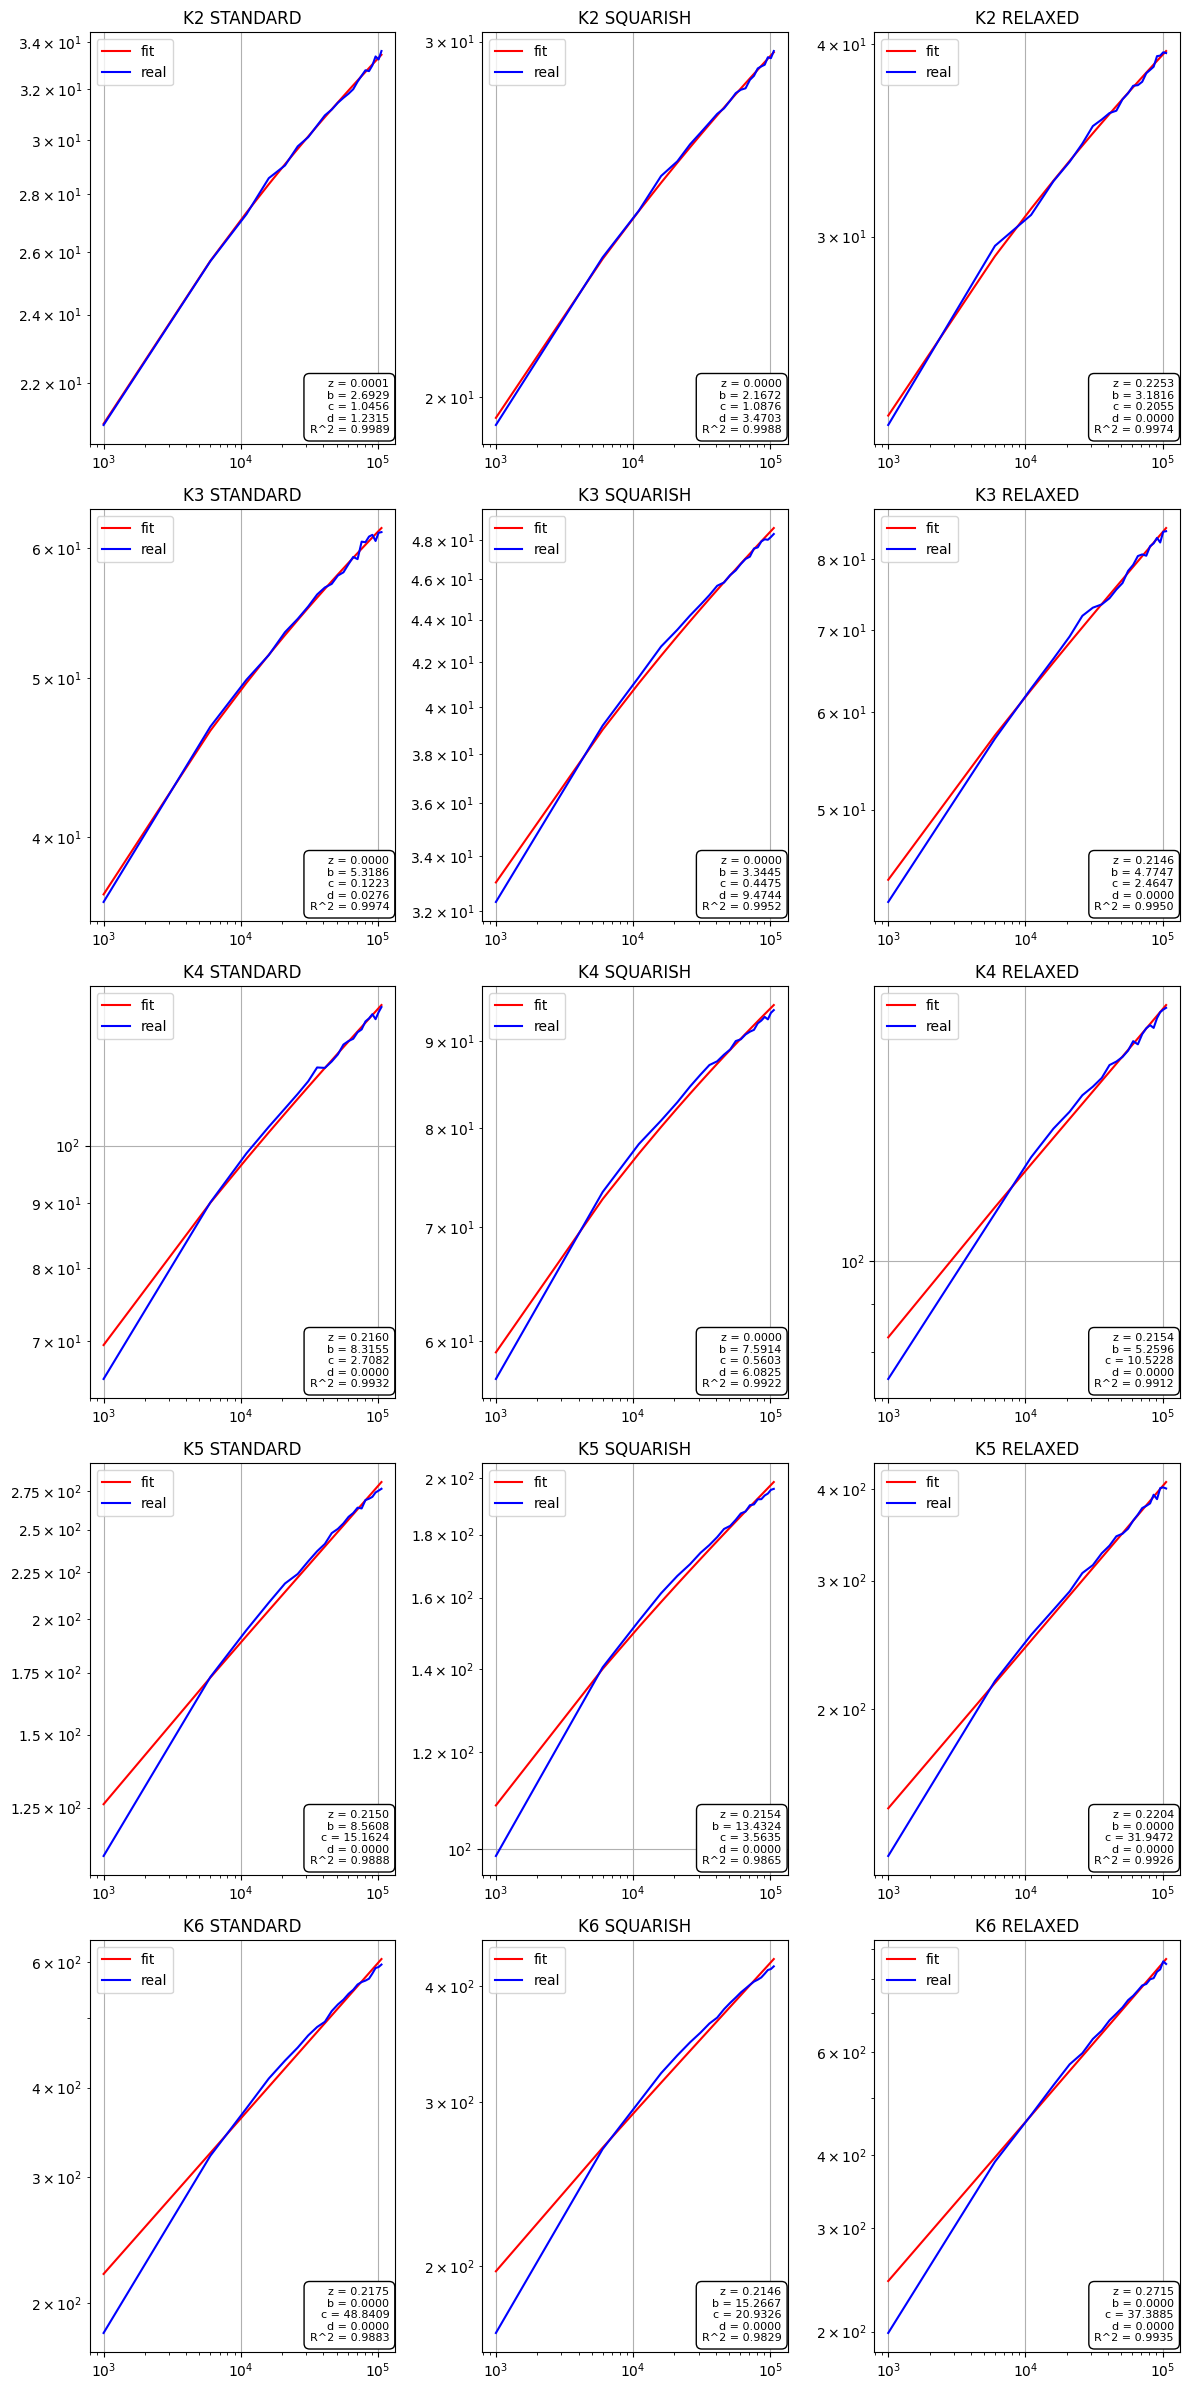

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares

# Función objetivo
def objective_function(n, a, b, c, d):
    return c*pow(n, a) + b*np.log(n) + d

# Función de residuos
def residuals(p, n, y):
    a, b, c, d = p
    return y - objective_function(n, a, b, c, d)

def residualR(X, Y):
    residuals = Y - objective_function(X, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Y - np.mean(Y))**2)
    return 1 - (ss_res / ss_tot)

fig, axs = plt.subplots(5, 3, figsize=(12, 24))

for k in range(2, 7):
    for i, method in enumerate(["STANDARD", "SQUARISH", "RELAXED"]):
        min_z = 0.01
        R_conf = 0.95
        r_squared = 0.00
        while (r_squared < R_conf):

            x0 = [min_z, 1, 1, 1]
            bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

            result = least_squares(residuals, x0, args=(results[k][method]['X'], results[k][method]['Y']), bounds=bounds)
            popt = result.x

            r_squared = residualR(results[k][method]['X'], results[k][method]['Y'])
            min_z = min_z + 0.01

        axs[k-2, i].loglog(results[k][method]['X'], objective_function(results[k][method]['X'], *popt), 'r-', label='fit')
        axs[k-2, i].loglog(results[k][method]['X'], results[k][method]['Y'], linestyle='-', color='blue', label='real')

        custom_text = f"z = {popt[0]:.4f}\nb = {popt[1]:.4f}\nc = {popt[2]:.4f}\nd = {popt[3]:.4f}\nR^2 = {r_squared:.4f}"
        axs[k-2, i].text(0.98, 0.02, custom_text, ha='right',fontsize=8, va='bottom', transform=axs[k-2, i].transAxes, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        axs[k-2, i].grid(True)
        axs[k-2, i].legend()
        axs[k-2, i].set_title('K'+str(k) + " " + method)

        print(f"K={k}, Método={method}")
        print("Estimated z:", popt[0], "with cov:")
        print("Estimated b:", popt[1], "with cov:")
        print("Estimated c:", popt[2], "with cov:")
        print("Estimated d:", popt[3], "with cov:")
        print("R^2:", r_squared)

fig.tight_layout()
plt.show()
